# Reference

[Flower-1-intro-to-FL-Pytorch](https://colab.research.google.com/github/adap/flower/blob/main/doc/source/tutorial/Flower-1-Intro-to-FL-PyTorch.ipynb#scrollTo=lA9tsoNz9OT7)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



# Installing dependencies

In [ ]:
!pip install -q flwr[simulation]
!pip install -U kaleido     # for using plotly library

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.2/157.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 25.

In [ ]:
from collections import OrderedDict
from typing import List, Tuple, Dict, Optional
import os
import sys
import time
import math

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision.datasets import CIFAR10

import flwr as fl
from flwr.common import Metrics

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.0.0+cu118 and Flower 1.4.0


# Utils

In [ ]:
def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias:
                init.constant(m.bias, 0)

# Loading the data

In [ ]:
CLASSES = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

In [ ]:
NUM_CLIENTS = 10
BATCH_SIZE = 128

In [ ]:
def load_datasets(divide=True):
    # Download and transform CIFAR-10 (train and test)

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform_train)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform_test)

    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    if divide:
        for ds in datasets:
            len_val = len(ds) // 10     # 10 % validation set
            len_train = len(ds) - len_val
            lengths = [len_train, len_val]
            ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
            trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
            valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    else:
        trainloaders.append(DataLoader(trainset, batch_size=128, shuffle=True))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = load_datasets(divide=False)

100%|██████████| 170498071/170498071 [00:13<00:00, 13070429.35it/s]


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset
Files already downloaded and verified


Take a look at the first batch of images and labels in the first training set (i.e., trainloaders[0]) before we move on.

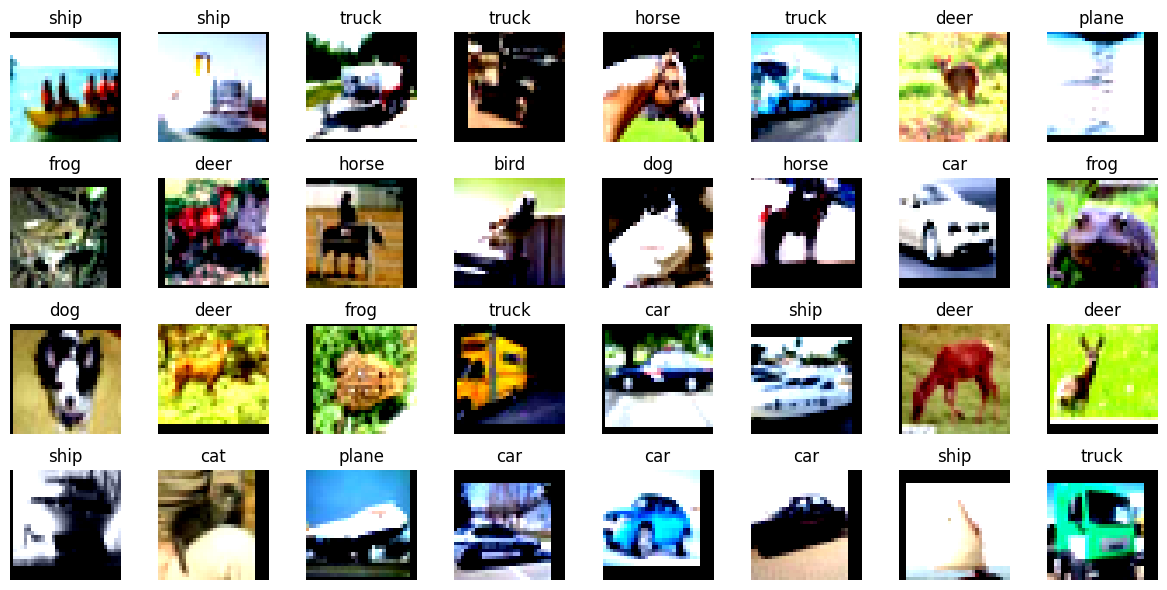

In [ ]:
images, labels = next(iter(trainloaders[0]))

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (hight, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(CLASSES[labels[i]])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()


# Step 1: Centralized Training with PyTorch

## Resnet-50
[github](https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py)

In [ ]:
# Resnet-18
# https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes=64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


## Train configuration


In [ ]:
net = ResNet50().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

Training and test functions

In [ ]:
def train(net, trainloader):
    """Train the network on the training set."""
    net.train()
    train_loss, correct, total = 0, 0, 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss /= len(trainloader.dataset)
    accuracy = correct / total

    return train_loss, accuracy


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    net.eval()
    test_loss, correct, total = 0, 0, 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    test_loss /= len(testloader)
    accuracy = correct / total

    return test_loss, accuracy

## Training the model

In [ ]:
save_path = "/content/drive/MyDrive/working/checkpoint/best_ckpt.pth"

trainloader = trainloaders[0]
#valloader = valloaders[0]
#net = ResNet50().to(DEVICE)

best_acc = 0
for epoch in range(1, 1001):
    train_loss, _ = train(net, trainloader)
    test_loss, accuracy = test(net, testloader)
    scheduler.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: validation loss {test_loss}, accuracy {accuracy}")
    if best_acc < accuracy:
        print(f'Saving...(epoch {epoch})')

        state = {
            'net': net.state_dict(),
            'acc': accuracy,
            'epoch': epoch,
        }
        torch.save(state, save_path)
        best_acc = accuracy
        

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

In [ ]:
best_model = torch.load(save_path)

net = ResNet50().to(DEVICE)
net.load_state_dict(best_model['net'])

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Final test set performance:
	loss 0.25099298034947887
	accuracy 0.9495


# Step 2 : Federated Learning with Flower

## Config

In [ ]:
# General
NUM_CLIENTS = 10
BATCH_SIZE = 128

## Make well-balanced dataset for FL clients

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = CIFAR10("./dataset", train=True, download=True, transform=transform_train)
testset = CIFAR10("./dataset", train=False, download=True, transform=transform_test)

print(len(trainset), len(testset))

100%|██████████| 170498071/170498071 [00:02<00:00, 78231725.60it/s]


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset
Files already downloaded and verified
50000 10000


In [ ]:
li_trainset = [torch.empty([0, 3, 32, 32]) for _ in range(10)]
labels = [[] for _ in range(10)]

for x, label in trainset:
    labels[label].append(label)
    li_trainset[label] = torch.cat((li_trainset[label], x[None, :]), dim=0)
    
labels = [torch.tensor(x) for x in labels]

In [ ]:
d_train = [torch.empty([0, 3, 32, 32]) for _ in range(NUM_CLIENTS)]
d_train_labels = [torch.tensor([], dtype=int) for _ in range(NUM_CLIENTS)]
ds_clients = []
dl_clients = []


for ds, label in zip(li_trainset, labels):
    indices = torch.randperm(5000)
    ds = ds[indices]
    label = label[indices]
    num_data = 5000 // NUM_CLIENTS
    for i in range(NUM_CLIENTS):
        d_train[i] = torch.cat((d_train[i], ds[i*num_data : (i+1)*num_data]), dim=0)
        d_train_labels[i] = torch.cat((d_train_labels[i], label[i*num_data : (i+1)*num_data]))

for i in range(NUM_CLIENTS):
    indices = torch.randperm(5000)
    d_train[i] = d_train[i][indices]
    d_train_labels[i] = d_train_labels[i][indices]
    ds_client = TensorDataset(d_train[i], d_train_labels[i])
    dl_client = DataLoader(
        ds_client,
        batch_size=BATCH_SIZE,
        shuffle=True,
    )
    ds_clients.append(ds_client)
    dl_clients.append(dl_client)

testloader = DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

print(len(ds_clients[0]), len(dl_clients[0]))

5000 40


## Train/Test function

In [ ]:
def train(net, trainloader, epochs=1):
    """Train the network on the training set."""
    net.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01,
                        momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    for epoch in range(epochs):

        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
        scheduler.step()


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    net.eval()
    test_loss, correct, total = 0, 0, 0
    
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    test_loss /= len(testloader)
    accuracy = correct / total

    return test_loss, accuracy

## Updating model parameters

In [ ]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


## Implementing a Flower client

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
    
    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}
    
    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


## Using the Virtual Client Engine

In [ ]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    #net = Net().to(DEVICE)
    net = ResNet50().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client 
    # will train and evaluate on their own unique data
    trainloader = dl_clients[int(cid)]
    #valloader = valloaders[int(cid)]
    valloader = testloader

    # Create a single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

## Evaluate global model

In [ ]:
def evaluate(
    server_round: int, parameters: fl.common.NDArrays, config: Dict[str, fl.common.Scalar]
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:

    #net = Net()
    net = ResNet50()
    set_parameters(net, parameters)
    loss, accuracy = test(net, testloader)
    
    return loss, {"loss": loss, "accuracy": accuracy} # The return type must be (loss, metric tuple) form

## Aggregate evaluation of local model

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    
    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

## Create FL strategy

In [ ]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,   # aggregate evaluation of local model
    evaluate_fn=evaluate,   # evaluate global model
    initial_parameters=fl.common.ndarrays_to_parameters(get_parameters(ResNet50())),
)

## FL simulation

### simulation parameters

In [ ]:
num_rounds = 5

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

### Simulate

In [ ]:
# Start simulation
hist = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=num_rounds),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-04-24 08:17:14,894 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-24 08:17:19,507	INFO worker.py:1553 -- Started a local Ray instance.
INFO flwr 2023-04-24 08:17:20,847 | app.py:180 | Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'object_store_memory': 3871850496.0, 'memory': 7743700992.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'object_store_memory': 3871850496.0, 'memory': 7743700992.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0}
INFO flwr 2023-04-24 08:17:20,857 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-04-24 08:17:20,863 | server.py:273 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client
(pid=37160) 2023-04-24 08:17:25.385691

Net: tensor([[[-0.1070, -0.1186, -0.0880],
         [-0.0786, -0.1542, -0.0062],
         [-0.0394,  0.0267,  0.1779]],

        [[-0.0003, -0.0114, -0.0923],
         [ 0.0866, -0.0060, -0.1598],
         [-0.1393, -0.0549, -0.1795]],

        [[-0.0389, -0.1164, -0.0529],
         [ 0.1856, -0.1190,  0.1258],
         [-0.0039,  0.1077, -0.1594]]])


IndexError: ignored

In [ ]:
metrics = list(hist.metrics_centralized.keys())

df_result = pd.DataFrame(
    columns=metrics,
)
df_result['round'] = [i for i in range(num_rounds + 1)]

for metric in metrics:
    df_result[metric] = [h[1] for h in hist.metrics_centralized[metric]]

print(df_result)

       loss  accuracy  round
0  0.072119    0.1000      0
1  0.061667    0.3069      1
2  0.053220    0.3809      2
3  0.049600    0.4196      3
4  0.047812    0.4447      4
5  0.046144    0.4649      5


# Plot the result graphs

In [ ]:
import plotly.graph_objects as go

round-loss

In [ ]:
print(df_result['accuracy'].values)

[0.1    0.3069 0.3809 0.4196 0.4447 0.4649]


In [ ]:
fig = go.Figure()
# Create and style traces
fig.add_trace(
    go.Scatter(
        x=df_result['round'].values[1:],
        y=df_result['loss'].values[1:],
    )
)

fig.update_layout(
    title="",
    xaxis_title="round",
    yaxis_title="loss",
    #plot_bgcolor="rgba(0,0,0,0)",
)

fig.show()